# ASHRAE - Great Energy Predictor III

# 0. General Project / Past Competition Information


- Aim: (Accurately) Predicting energy consumption of commercial buildings. (Calculate djusted baseline energy while measured energy and weather conditions are known.)
- Dataset: 20 million rows, covering three years of hourly data from 2,380 meters ({0: electricity, 1: chilledwater, 2: steam, 3: hotwater}) across 1,448 commercial buildings

Kaggle Competition link: https://www.kaggle.com/competitions/ashrae-energy-prediction/data 

*Model Selection*:
- Gradient Boosting Machines (GBMs) - esp. LightGBM (the most due to effc.)
- Ensemble methods (XGBoost)
- TSML? time-series
- NN, CatBoost

- Cross-validation (model tuning, time-based split - train on 2016, calidate on 2017)

*Evaluation Metric*:
Root Mean Squared Logarithmic Error (RMSLE):

$\sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \log(1 + \hat{y}_i) - \log(1 + y_i) \right)^2}$

### Issues & Questions
- Data size is big, not easy to process each time. Sampling?
- Should I fillna() the missing data with median etc.? - air_temperature, cloud_coverage? or dropna()?

- Train with sample or whole set?
- Any need to split the set train-test-validate? It's already in train-test format.

### Ideas / Solutions:
- fraction by 1% or 0.5%
- aggregate data (not hourly but daily sum (for short-term), monthly sum (for longer-term) etc.) -> loss of time-series data (HVAC load may differ in a day)
- go with one building and scale up later -> may not generalize later? (instead, start with single site (same climate zone) and meter?)

- DROP COLS: floor_count remove, year_built remove it (you can sample out non missing, and then use that to subsample? but in practice). for ai. cloud_coverage drop
- IMPUTATION: precipitation -> do some imputation, explore and figure out the trend (is it dependent on other features? - linregression?) - linreg or median would work. sea_level_pres (meand/meadian would be fine) and wind direction (circular mean imputation or use sine/cosine transformation)
- DROP ROWS: for dew and air temp, drop the rows only if less than 5%
- monthly aggregation?
- remove zeros??? - why? explanation -> operational hours, due to sensor faults / missing values
- R2 - why that low?

### Observations:
- Scatter plot (log-temp): Electricity usage depends on more than just temperature—it’s influenced by HVAC, occupancy, and operational patterns.
-  low R² (~0.14) suggests a weak linear relationship. This is expected because energy consumption is influenced by non-linear factors like HVAC control strategies, occupancy, and weather variability. -> Try tree-based models (XGBoost, Random Forest) might improve R².
- Instead of blindly dropping year_built, you could derive building_age (2025 - year_built).
For cloud_coverage, check if it correlates with energy usage before removing it.
wind_direction is cyclical (0° and 360° are the same). You might transform it into sin(wind_direction) and cos(wind_direction).
- Train separate models for different meter types. Electricity (meter=0) behaves differently from chilled water (meter=1).
- Many outliers in the meter_reading. Log transformation is necessary!


### Model Selection:

_Ideas compiled after Clarence's feedback:_
- GBM: Ensemble method to combine many weak learners into one, strong model. No individual feature feature with high correlation (with the targeted meter reading) in the dataset. Instead, many weak predictors that could combine into a strong predictive model. _Moderate_

Note: GBM is tree-based, consider: <font color='red'>**decision tree, random forest (ensemble of trees) and GBM**</font>

- <font color='red'>k-nearest neighbor</font>: Might make sense since the dataset is huge with 20,000,000 rows and kNN becomes a "look-up table", where predicted meter reading is related to similar buildings in similar geographic regions [site] (i.e., the “closest” buildings).

- <font color='red'>**Deep learning**</font>: i.e. Transfer learning since it's mentioned as one of the best methods for dealing with the limited, low-quality datasets in the built environment. Building stocks often lack sufficient labeled data, transfer learning could be useful even with just a few exemplary cases. 

_Ideas compiled after Arav's feedback:_
- Boosting techniques would work (not CatBoost though since it takes a very long time to train)
- <font color='red'>**XGBoost**</font> is a strong model, definitely try it out. Might take a long time due to the dataset size. Also, it doesn't like categorical data. If you are able to figure out ways to cut down on the features, you can use XGB easily. Maybe try out Decision Trees feature importance/Logistic Regression coeffs?

- <font color='red'>**LightGBM**</font> should work really well -designed to do efficient computation.
- <font color='red'>**RNN**</font> would work since some of the features are time-series. Though, it's better to look at ML techniques before DL techniques.
Time-series models can also be used to do feature imputation (it may be a bit complex, though).

_Ideas overall:_
- Splitting? train-validate-test
- 



# 1. Libraries & Data Set-up

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Merged dataset

In [3]:
# train = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/train.csv')
# building_metadata = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/building_metadata.csv')
# weather_train = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/weather_train.csv')

# test = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/test.csv')
# weather_test = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/weather_test.csv')

In [4]:
# print("-----------\nTrain Data:")
# display(train.head())
# print(train.info())
# print(f'Size of train data: {train.shape}')
# print("-----------\nBuilding Metadata:")
# display(building_metadata.head())
# print(building_metadata.info())
# print(f'Size of building_metadata data: {building_metadata.shape}')
# print("-----------\nWeather Train Data:")
# display(weather_train.head())
# print(weather_train.info())
# print(f'Size of weather_train data: {weather_train.shape}')

# '''
# Size of train_df data (20216100, 4)
# Size of weather_train_df data (139773, 9)
# Size of weather_test_df data (277243, 9)
# Size of building_meta_df data (1449, 6)
# '''

Merging train + building_metadata + weather_train -> **'train_merged'** (via 'building_id' and 'site_id')

In [5]:
train_merged = 'train_merged_cache.csv'
# import os
# cache_file = 'train_merged_cache.csv'

# if os.path.exists(cache_file):
#     train_merged = pd.read_csv(cache_file)
# else:
#     train_merged = pd.merge(train, building_metadata, on='building_id', how='left')
#     train_merged = pd.merge(train_merged, weather_train, on=['site_id', 'timestamp'], how='left')
#     train_merged.to_csv(cache_file, index=False)

# # display(train_merged.head()) # train + building_metadata + weather_train 

Checking missing data (train_merged)

In [6]:
# missing_values = train_merged.isnull().sum()
# print("Missing values in each column:")
# print(missing_values[missing_values > 0])

# total = train_merged.isnull().sum().sort_values(ascending = False)
# percent = (train_merged.isnull().sum()/train_merged.isnull().count()*100).sort_values(ascending = False)
# missing__train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent (%)'])
# missing__train_data['Percent (%)'] = missing__train_data['Percent (%)'].map('{:.2f}'.format)
# display(missing__train_data)

## Sampling (For faster processing)

In [7]:
import random
# for i in range(10):
#     sample = train_merged.sample(frac=0.05, random_state=i)
#     sample.to_csv(f'train_sample_{i}.csv', index=False)

random_sample_index = random.randint(0, 9)
train_sample = pd.read_csv(f'train_sample_{random_sample_index}.csv')
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010805 entries, 0 to 1010804
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   building_id         1010805 non-null  int64  
 1   meter               1010805 non-null  int64  
 2   timestamp           1010805 non-null  object 
 3   meter_reading       1010805 non-null  float64
 4   site_id             1010805 non-null  int64  
 5   primary_use         1010805 non-null  object 
 6   square_feet         1010805 non-null  int64  
 7   year_built          404440 non-null   float64
 8   floor_count         175191 non-null   float64
 9   air_temperature     1005935 non-null  float64
 10  cloud_coverage      570314 non-null   float64
 11  dew_temperature     1005761 non-null  float64
 12  precip_depth_1_hr   823014 non-null   float64
 13  sea_level_pressure  949231 non-null   float64
 14  wind_direction      938282 non-null   float64
 15  wind_speed     

## Pre-processing

Visualizing missing values (heatmap):

In [8]:
# plt.figure(figsize=(10, 6))
# sns.heatmap(train_sample.isnull(), cbar=False, yticklabels=False)
# plt.title("Missing Values in Sampled Data (frac=0.05)")
# plt.show()

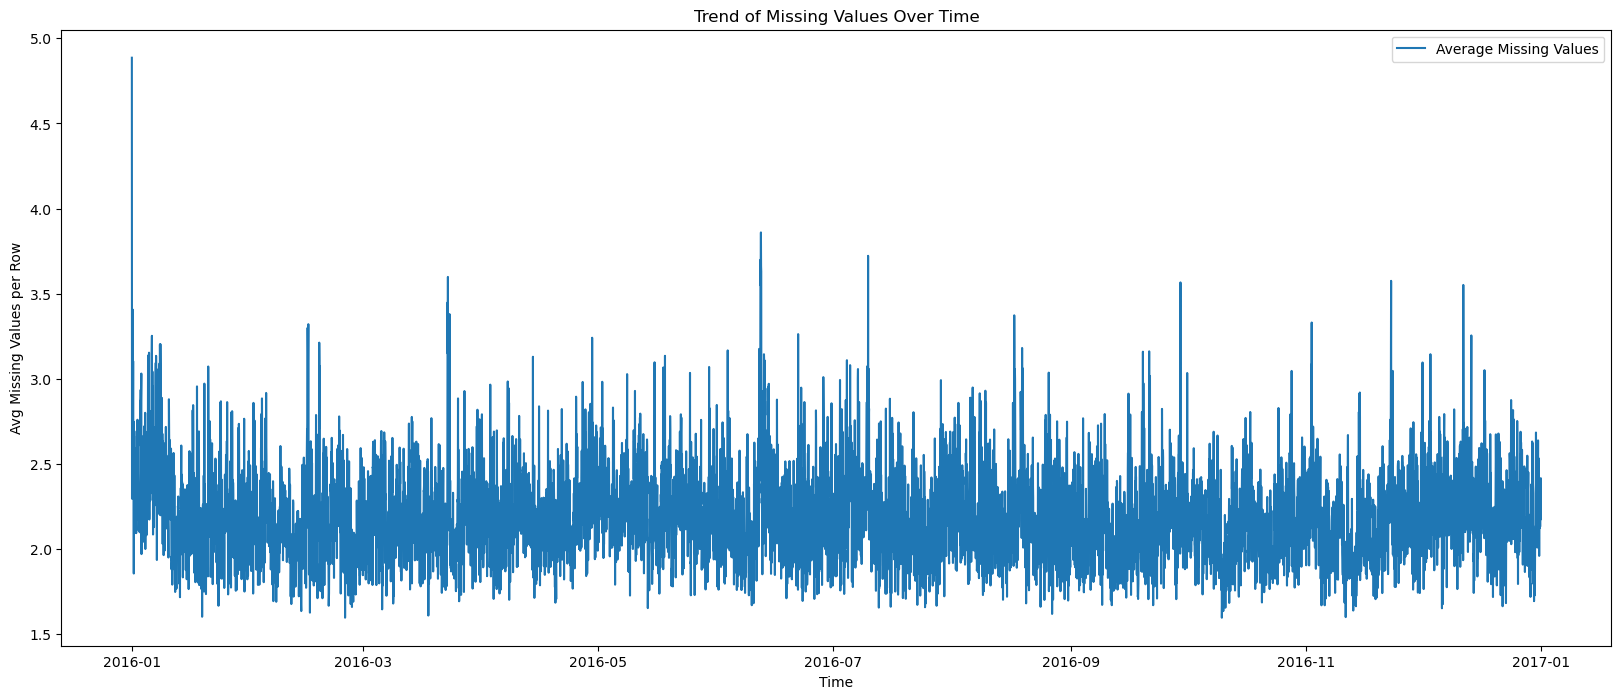

In [9]:
train_sample['timestamp'] = pd.to_datetime(train_sample['timestamp'])
train_sample['missing_values'] = train_sample.isnull().sum(axis=1)
missing_over_time = train_sample.groupby('timestamp')['missing_values'].mean()

plt.figure(figsize=(20, 8))
plt.plot(missing_over_time, label='Average Missing Values')
plt.xlabel('Time')
plt.ylabel('Avg Missing Values per Row')
plt.title('Trend of Missing Values Over Time')
plt.legend()
plt.show()

/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_24734/4243165697.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_use = train_sample.groupby('primary_use').apply(lambda x: x.isnull().mean() * 100)


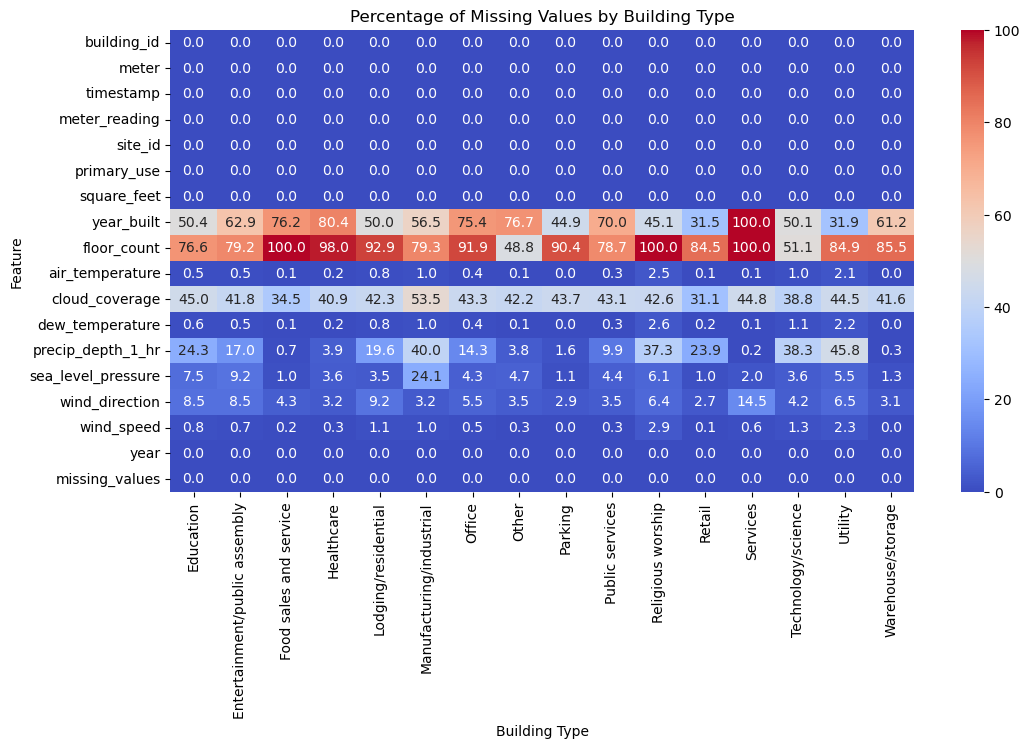

In [10]:
missing_by_use = train_sample.groupby('primary_use').apply(lambda x: x.isnull().mean() * 100)
plt.figure(figsize=(12, 6))
sns.heatmap(missing_by_use.T, cmap='coolwarm', annot=True, fmt=".1f")
plt.title('Percentage of Missing Values by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Feature')
plt.xticks(rotation=90)
plt.show()

/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_24734/173180020.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_meter = train_sample.groupby('meter').apply(lambda x: x.isnull().mean() * 100)


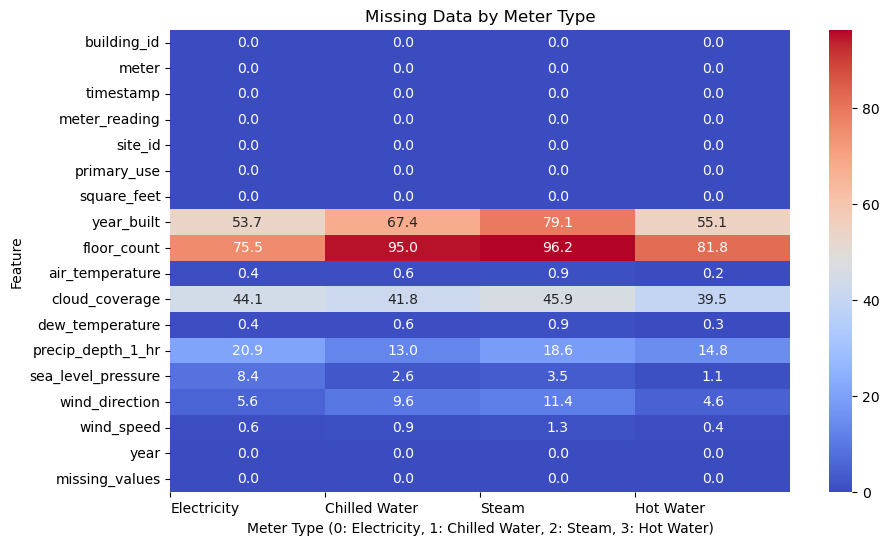

In [11]:
missing_by_meter = train_sample.groupby('meter').apply(lambda x: x.isnull().mean() * 100)

plt.figure(figsize=(10, 6))
sns.heatmap(missing_by_meter.T, cmap='coolwarm', annot=True, fmt=".1f")
plt.title('Missing Data by Meter Type')
plt.xlabel('Meter Type (0: Electricity, 1: Chilled Water, 2: Steam, 3: Hot Water)')
plt.ylabel('Feature')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Electricity', 'Chilled Water', 'Steam', 'Hot Water'], ha='left')
plt.show()

/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_24734/386703477.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_site = train_sample.groupby('site_id').apply(lambda x: x.isnull().mean() * 100)


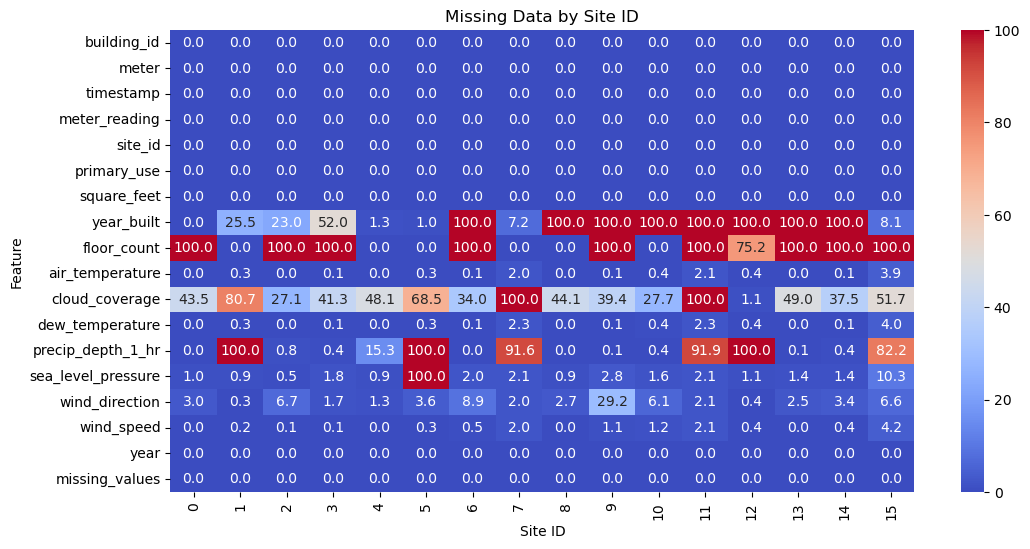

In [12]:
missing_by_site = train_sample.groupby('site_id').apply(lambda x: x.isnull().mean() * 100)

plt.figure(figsize=(12, 6))
sns.heatmap(missing_by_site.T, cmap="coolwarm", annot=True, fmt=".1f")
plt.title('Missing Data by Site ID')
plt.xlabel('Site ID')
plt.ylabel('Feature')
plt.xticks(rotation=90)
plt.show()

### Feature Engineering & Selection

Feature creation:

In [13]:
thresh_temp = 18 # outside air_temp
train_sample['HDH'] = train_sample['air_temperature'].apply(lambda x: max(thresh_temp - x, 0)) # heating degree hours
train_sample['CDH'] = train_sample['air_temperature'].apply(lambda x: max(x - thresh_temp, 0)) # cooling degree days

train_sample['wind_chill_effect'] = train_sample['wind_speed'] * (thresh_temp - train_sample['air_temperature']) # + -> heat loss, - -> can work as natural cooling

train_sample['wind_sin'] = np.sin(np.radians(train_sample['wind_direction']))
train_sample['wind_cos'] = np.cos(np.radians(train_sample['wind_direction']))

train_sample['hour'] = pd.to_datetime(train_sample['timestamp']).dt.hour
train_sample['day'] = pd.to_datetime(train_sample['timestamp']).dt.day
train_sample['weekday'] = pd.to_datetime(train_sample['timestamp']).dt.weekday # 1,2,3,4,5,6,7
train_sample['month'] = pd.to_datetime(train_sample['timestamp']).dt.month

def assign_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

train_sample['season'] = train_sample['month'].apply(assign_season)

# train_sample['is_peak'] = train_sample['hour'].apply(lambda x: 1 if 7 <= x <= 19 else 0)
# train_sample['is_night'] = train_sample['hour'].apply(lambda x: 1 if x < 6 or x > 22 else 0)

train_sample['building_age'] = 2024 - train_sample['year_built']

train_sample.sort_values(by='building_id', inplace=True)

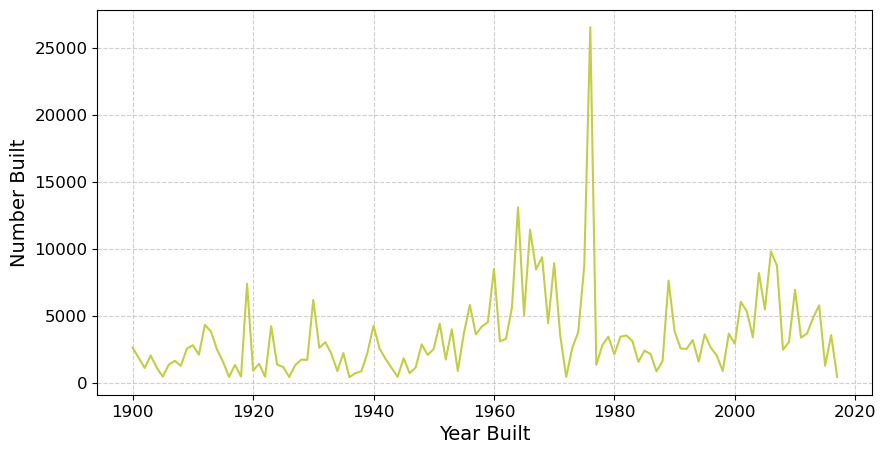

In [14]:
year_built_counts = train_sample['year_built'].dropna().astype(int).value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.lineplot(x=year_built_counts.index, y=year_built_counts.values, color="#C2CE46")

plt.xlabel("Year Built", fontsize=14)
plt.ylabel("Number Built", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Imputation / Drop for missing values:

In [15]:
train_sample['precip_depth_1_hr'].fillna(train_sample['precip_depth_1_hr'].median(), inplace=True)
train_sample['sea_level_pressure'].fillna(train_sample['sea_level_pressure'].median(), inplace=True)
train_sample['wind_direction'].fillna(train_sample['wind_direction'].median(), inplace=True)
train_sample['building_age'].fillna(train_sample['building_age'].median(), inplace=True)

train_sample['log_meter_reading'] = np.log1p(train_sample['meter_reading'])

train_sample.drop(columns=['timestamp', 'wind_speed', 'air_temperature', 'dew_temperature', 'wind_direction', 'floor_count','cloud_coverage', 'year_built', 'missing_values'], inplace=True)

/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_24734/1686710835.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_sample['precip_depth_1_hr'].fillna(train_sample['precip_depth_1_hr'].median(), inplace=True)
/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_24734/1686710835.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the inter

In [16]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010805 entries, 534236 to 994050
Data columns (total 21 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   building_id         1010805 non-null  int64  
 1   meter               1010805 non-null  int64  
 2   meter_reading       1010805 non-null  float64
 3   site_id             1010805 non-null  int64  
 4   primary_use         1010805 non-null  object 
 5   square_feet         1010805 non-null  int64  
 6   precip_depth_1_hr   1010805 non-null  float64
 7   sea_level_pressure  1010805 non-null  float64
 8   year                1010805 non-null  int64  
 9   HDH                 1005935 non-null  float64
 10  CDH                 1005935 non-null  float64
 11  wind_chill_effect   1003552 non-null  float64
 12  wind_sin            938282 non-null   float64
 13  wind_cos            938282 non-null   float64
 14  hour                1010805 non-null  int32  
 15  day             

Segmentation by Meter Type:


In [17]:
electric_data = train_sample[train_sample['meter'] == 0]
chilled_water_data = train_sample[train_sample['meter'] == 1]
steam_data = train_sample[train_sample['meter'] == 2]
hotwater_data = train_sample[train_sample['meter'] == 3]

In [18]:
'''plt.figure(figsize=(5, 3))
sns.scatterplot(x='air_temperature', y=train_sample['log_meter_reading'], s=5, color='darkblue', alpha=0.5, data=train_sample)
plt.xlabel('Air Temperature (°C)')
plt.ylabel('Log Meter Reading (kWh)')
plt.title('Energy Use vs Air Temperature')
plt.show()

# for different meter types
colors = {0: 'gray', 1: 'green', 2: 'red', 3: 'purple'}
meter_types = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

for meter_id, meter_name in meter_types.items():
    plt.figure(figsize=(5, 3))
    sns.scatterplot(x='air_temperature', y='log_meter_reading', s=5, color=colors[meter_id], alpha=0.5, data=train_sample[train_sample['meter'] == meter_id])
    plt.xlabel('Air Temperature (°C)')
    plt.ylabel('Log Meter Reading (kWh)')
    plt.title(f'Energy Use vs Air Temperature ({meter_name})')
    plt.show()'''

"plt.figure(figsize=(5, 3))\nsns.scatterplot(x='air_temperature', y=train_sample['log_meter_reading'], s=5, color='darkblue', alpha=0.5, data=train_sample)\nplt.xlabel('Air Temperature (°C)')\nplt.ylabel('Log Meter Reading (kWh)')\nplt.title('Energy Use vs Air Temperature')\nplt.show()\n\n# for different meter types\ncolors = {0: 'gray', 1: 'green', 2: 'red', 3: 'purple'}\nmeter_types = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}\n\nfor meter_id, meter_name in meter_types.items():\n    plt.figure(figsize=(5, 3))\n    sns.scatterplot(x='air_temperature', y='log_meter_reading', s=5, color=colors[meter_id], alpha=0.5, data=train_sample[train_sample['meter'] == meter_id])\n    plt.xlabel('Air Temperature (°C)')\n    plt.ylabel('Log Meter Reading (kWh)')\n    plt.title(f'Energy Use vs Air Temperature ({meter_name})')\n    plt.show()"

# 2. Initial EDA (assg#2)

Set graphical standards!

In [19]:
# plt.style.use('ggplot')
# color = 'darkblue'
# sns.set_theme(style="whitegrid", palette="muted")

sns.despine(left=True, bottom=True)
sns.set_theme(style="whitegrid", 
              rc={"axes.labelsize": 14, "axes.titlesize": 16, 
                  "xtick.labelsize": 12, "ytick.labelsize": 12, 
                  "axes.titleweight": "regular", "axes.labelweight": "regular", 
                  "grid.linestyle": "--", "grid.alpha": 0.5, 
                  "font.family": "sans-serif", "font.weight": "regular"})

# Custom color palette to match ggplot2
custom_palette = ["#5EB296", "#4E9EBA", "#F29239", "#C2CE46", "#FF7A7F", "#4D4D4D"]
sns.set_palette(custom_palette)

<Figure size 640x480 with 0 Axes>

1. Histogram - log_meter_reading distribution

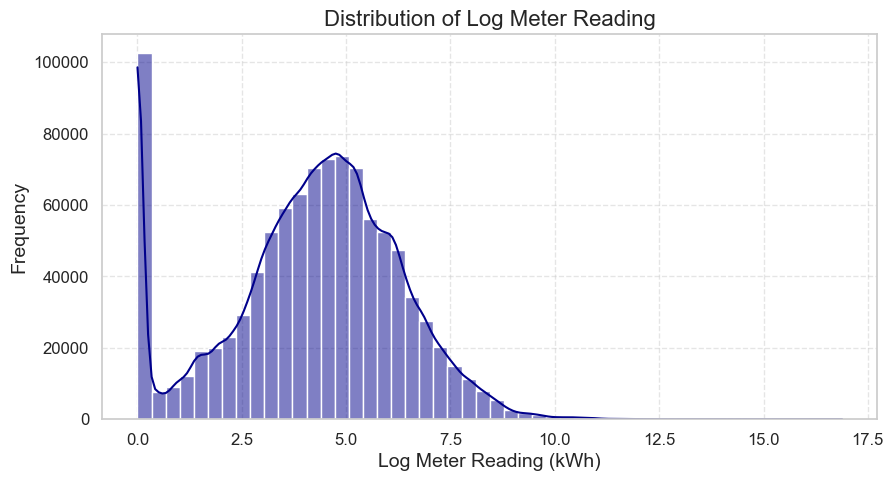

In [20]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(10, 5))
sns.histplot(train_sample['log_meter_reading'], bins=50 ,kde=True, color='darkblue')
plt.title('Distribution of Log Meter Reading')
plt.xlabel('Log Meter Reading (kWh)')
plt.ylabel('Frequency')

plt.show()

Understanding zeros:

/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_24734/2391367361.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=zero_readings, x='hour', palette='viridis', ax=axes[0])
/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_24734/2391367361.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=zero_readings, x='month', palette='viridis', ax=axes[1])
/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_24734/2391367361.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=zero_electricity, x='primar

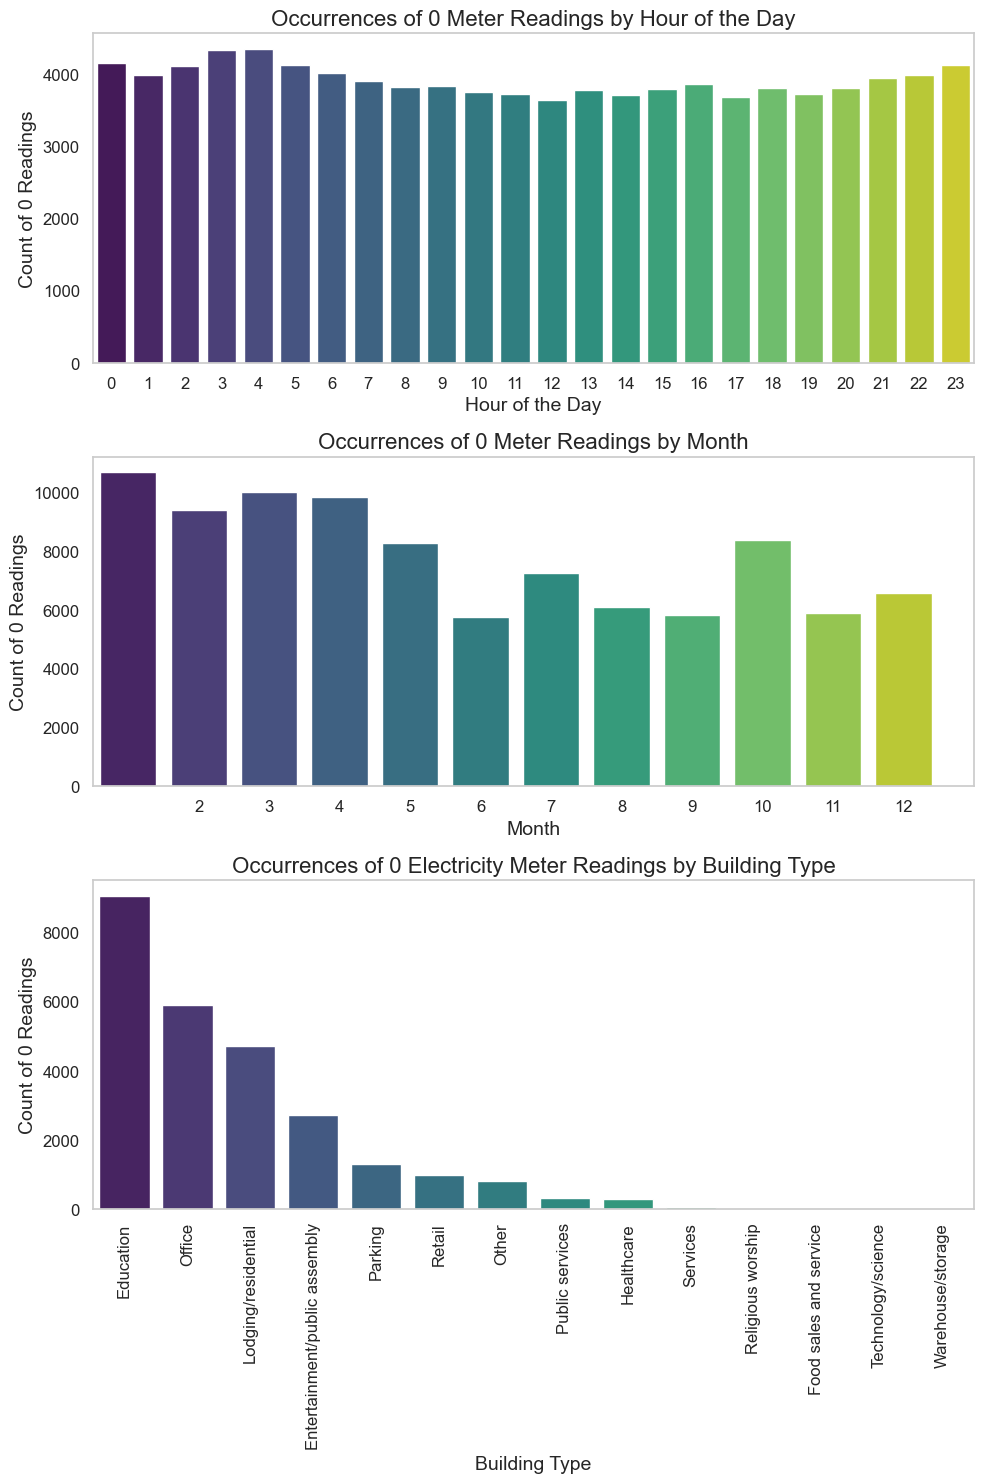

In [59]:
zero_readings = train_sample[train_sample['meter_reading'] == 0]
zero_electricity = zero_readings[zero_readings['meter'] == 0]

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

sns.countplot(data=zero_readings, x='hour', palette='viridis', ax=axes[0])
axes[0].set_title('Occurrences of 0 Meter Readings by Hour of the Day')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Count of 0 Readings')
axes[0].set_xticks(range(24))
axes[0].grid(axis='y')

sns.countplot(data=zero_readings, x='month', palette='viridis', ax=axes[1])
axes[1].set_title('Occurrences of 0 Meter Readings by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count of 0 Readings')
axes[1].set_xticks(range(1, 13))
axes[1].grid(axis='y')

sns.countplot(data=zero_electricity, x='primary_use', palette='viridis', ax=axes[2], order=zero_electricity['primary_use'].value_counts().index)
axes[2].set_title('Occurrences of 0 Electricity Meter Readings by Building Type')
axes[2].set_xlabel('Building Type')
axes[2].set_ylabel('Count of 0 Readings')
axes[2].set_xticks(zero_electricity['primary_use'].unique())
axes[2].tick_params(axis='x', rotation=90)
axes[2].grid(axis='y')


plt.tight_layout()
plt.show()




In [60]:
train_sample['zero_flag'] = (train_sample['meter'] == 0) & (train_sample['meter_reading'] == 0)
train_sample.groupby('building_id')['zero_flag'].mean().sort_values(ascending=False).head(10)

building_id
53      0.934066
1221    0.838407
857     0.673516
853     0.631961
1113    0.588785
817     0.552058
815     0.535897
45      0.497748
1446    0.478386
86      0.461538
Name: zero_flag, dtype: float64

"Highest median reading during the middle of the day"

Lowest Point - Hour: 3.0, Median Reading: 60.07
Highest Point - Hour: 12.0, Median Reading: 97.0


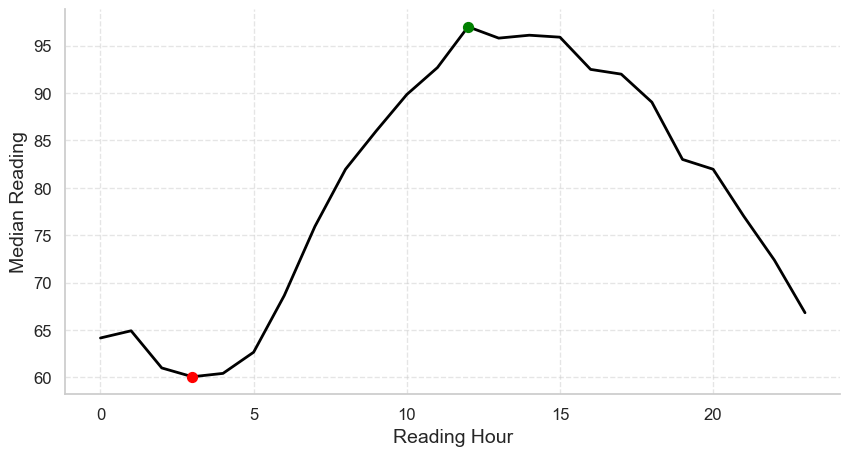

In [61]:
hourly_median = train_sample.groupby('hour')['meter_reading'].median().reset_index()

plt.figure(figsize=(10, 5))

sns.lineplot(data=hourly_median, x='hour', y='meter_reading', color='#000000', linewidth=2)

plt.xlabel("Reading Hour", fontsize=14)
plt.ylabel("Median Reading", fontsize=14)

lowest_point = hourly_median.loc[hourly_median['meter_reading'].idxmin()]
highest_point = hourly_median.loc[hourly_median['meter_reading'].idxmax()]
print(f"Lowest Point - Hour: {lowest_point['hour']}, Median Reading: {lowest_point['meter_reading']}")
print(f"Highest Point - Hour: {highest_point['hour']}, Median Reading: {highest_point['meter_reading']}")

plt.scatter(lowest_point['hour'], lowest_point['meter_reading'], color='red', s=50, zorder=5)
plt.scatter(highest_point['hour'], highest_point['meter_reading'], color='green', s=50, zorder=5)
sns.despine()

plt.show()

Text(0, 0.5, '')

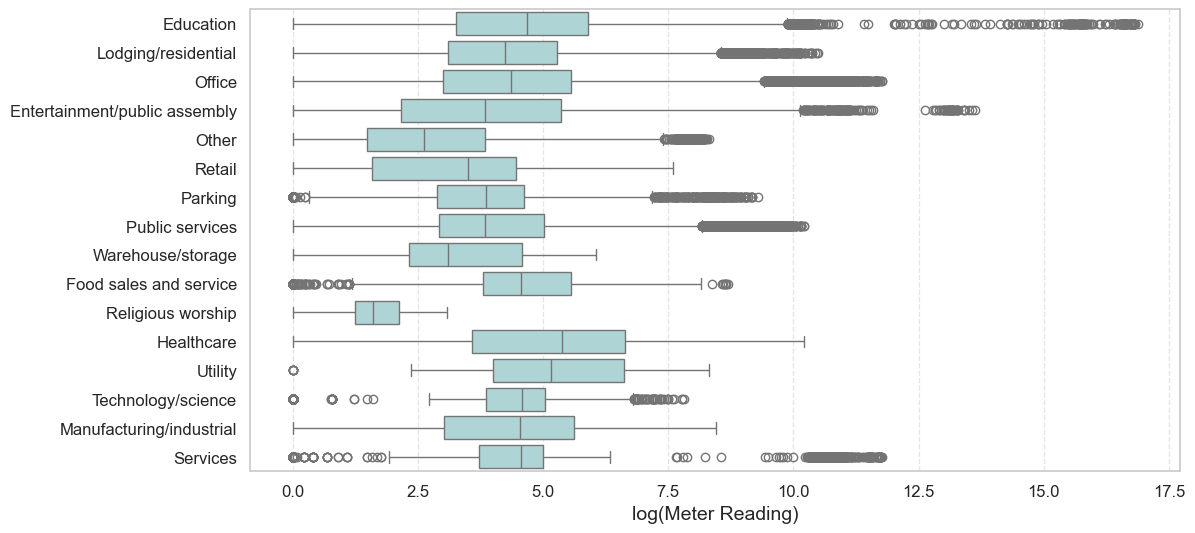

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_sample, x="log_meter_reading", y="primary_use", color="#a8dadc")
plt.xlabel("log(Meter Reading)", fontsize=14)
plt.ylabel("")

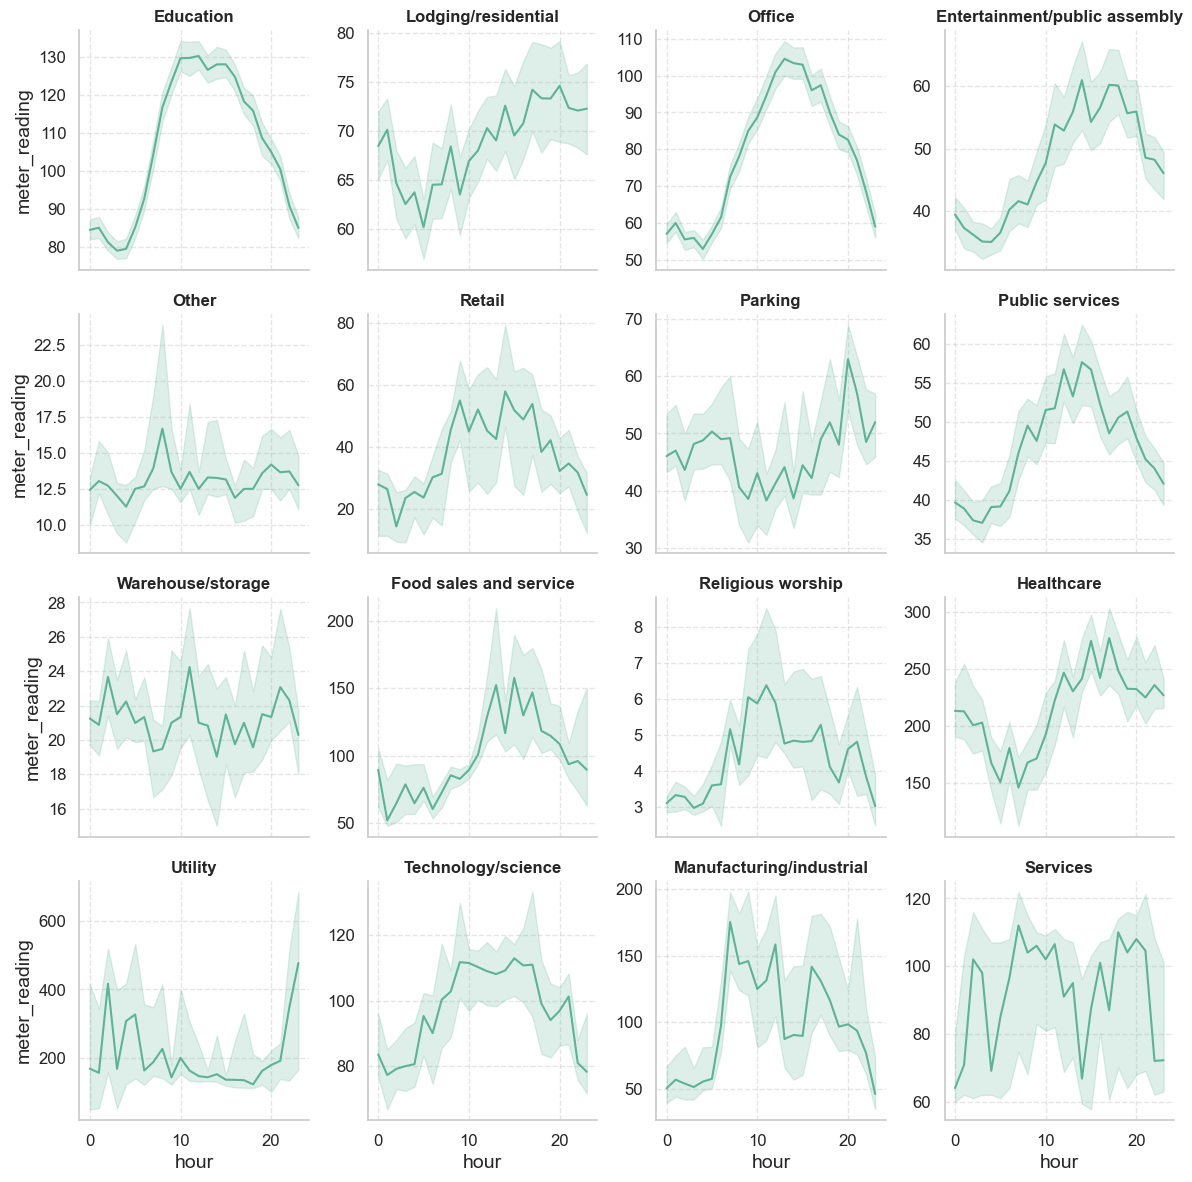

In [24]:
g = sns.FacetGrid(train_sample,col="primary_use", col_wrap=4, height=3, sharey=False)
g.map_dataframe(sns.lineplot, x="hour", y="meter_reading", estimator="median")

g.set_titles(col_template="{col_name}", size=12, fontweight="bold")
plt.show()

"Education buildings have by far the most readings"

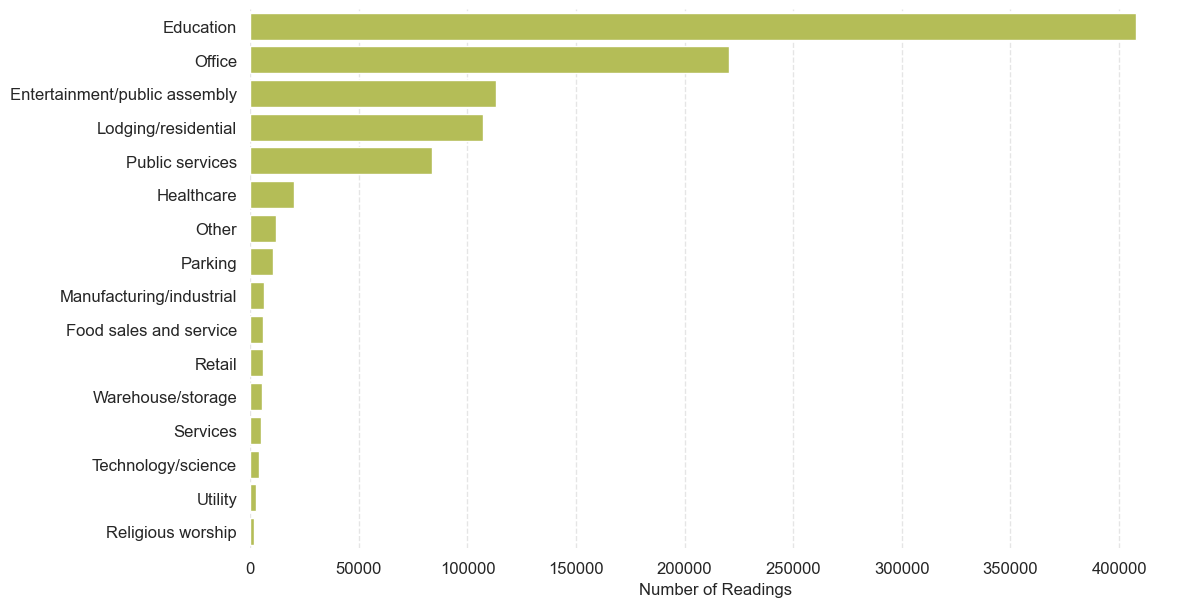

In [27]:
building_counts = train_sample["primary_use"].value_counts().reset_index()
building_counts.columns = ["Building Type", "Number of Readings"]
building_counts = building_counts.sort_values(by="Number of Readings", ascending=False)

plt.figure(figsize=(12, 7))
ax = sns.barplot(y="Building Type", x="Number of Readings", data=building_counts, color="#C2CE46")

sns.despine(left=True, bottom=True)
plt.xlabel("Number of Readings", fontsize=12)
plt.ylabel("")
plt.show()


"Building size is positively skewed"

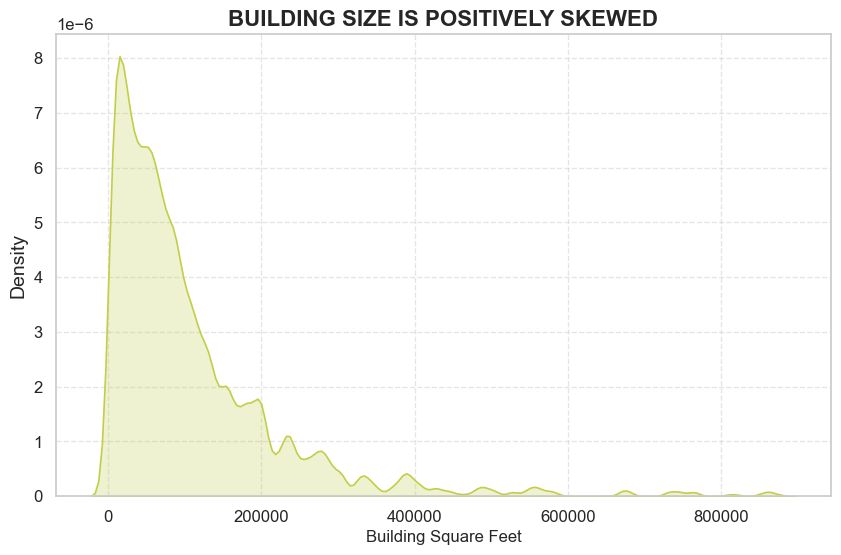

In [81]:
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(train_sample["square_feet"], fill=True, color="#C2CE46", linewidth=1.2)
plt.xlabel("Building Square Feet", fontsize=12)
plt.ylabel("Density")
plt.show()

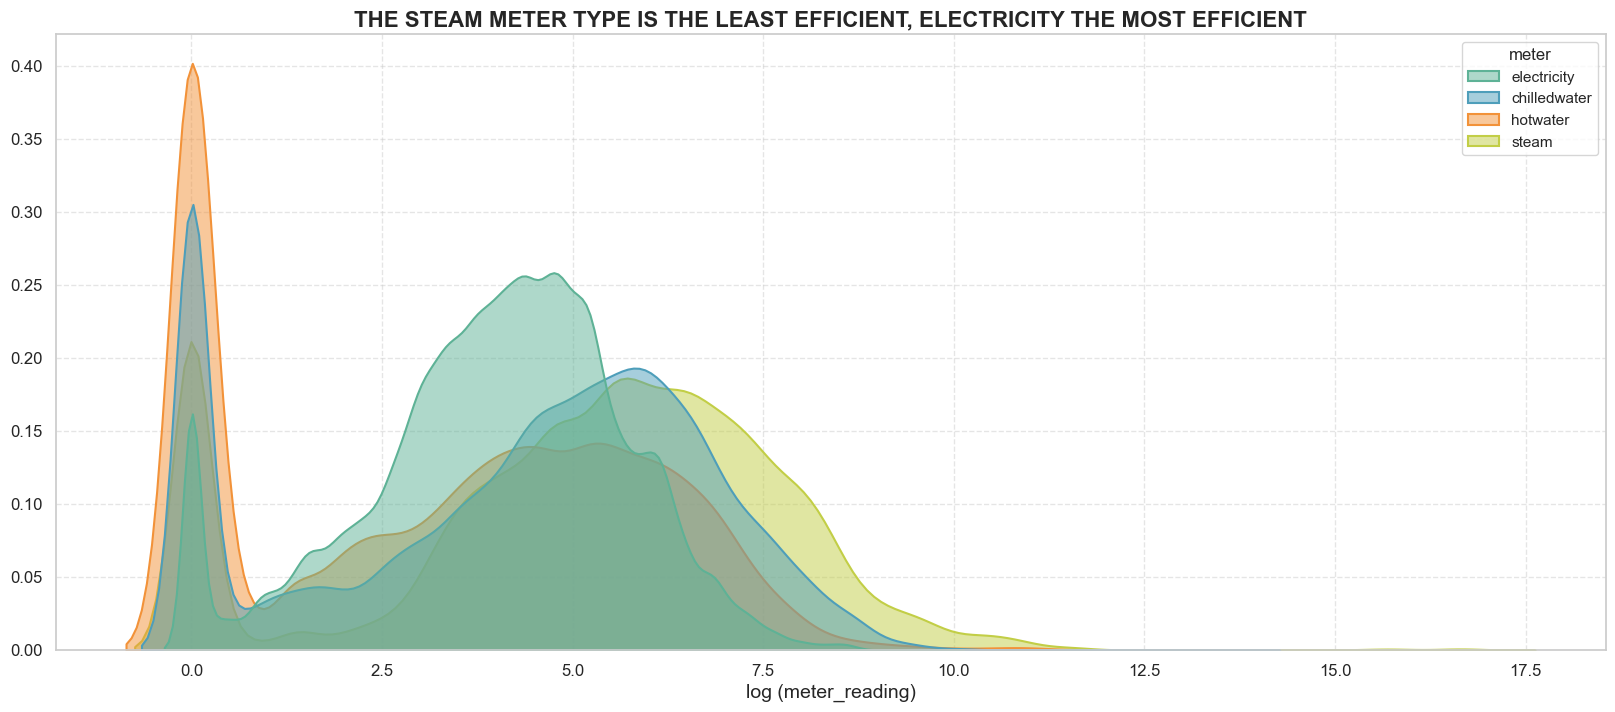

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

In [36]:
plt.figure(figsize=(20, 8))
sns.kdeplot(data=train_sample, x=np.log1p(train_sample['meter_reading']), hue=train_sample['meter'].map({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}), fill=True, common_norm=False, alpha=0.5, linewidth=1.5)

plt.title("THE STEAM METER TYPE IS THE LEAST EFFICIENT, ELECTRICITY THE MOST EFFICIENT", fontsize=16, fontweight='bold', loc='center')
plt.xlabel("log (meter_reading)")
plt.ylabel("")
plt.show()

plt.figure(figsize=(20, 8))

2. Scatter Plot - relationship bw log_meter_reading (energy use) and air_temperature

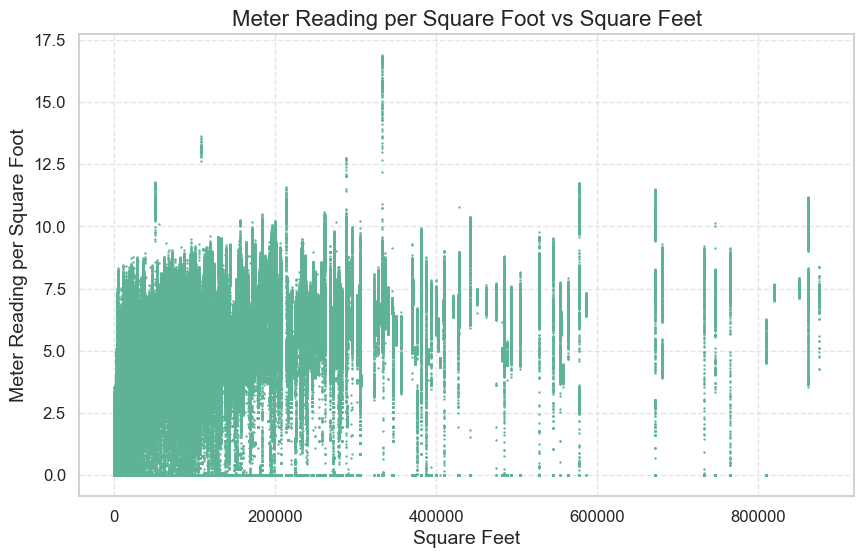

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(train_sample['square_feet'], train_sample['log_meter_reading'], s=0.5)
plt.xlabel('Square Feet')
plt.ylabel('Meter Reading per Square Foot')
plt.title('Meter Reading per Square Foot vs Square Feet')
plt.show()

3. Correlation Heatmap - relationship between air_temperature and log_meter_reading.

In [63]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010805 entries, 534236 to 994050
Data columns (total 22 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   building_id         1010805 non-null  int64  
 1   meter               1010805 non-null  int64  
 2   meter_reading       1010805 non-null  float64
 3   site_id             1010805 non-null  int64  
 4   primary_use         1010805 non-null  object 
 5   square_feet         1010805 non-null  int64  
 6   precip_depth_1_hr   1010805 non-null  float64
 7   sea_level_pressure  1010805 non-null  float64
 8   year                1010805 non-null  int64  
 9   HDH                 1005935 non-null  float64
 10  CDH                 1005935 non-null  float64
 11  wind_chill_effect   1003552 non-null  float64
 12  wind_sin            938282 non-null   float64
 13  wind_cos            938282 non-null   float64
 14  hour                1010805 non-null  int32  
 15  day             

In [99]:
cols = train_sample.columns
cols

Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'precip_depth_1_hr', 'sea_level_pressure', 'year', 'HDH',
       'CDH', 'wind_chill_effect', 'wind_sin', 'wind_cos', 'hour', 'day',
       'weekday', 'month', 'season', 'building_age', 'log_meter_reading',
       'zero_flag'],
      dtype='object')

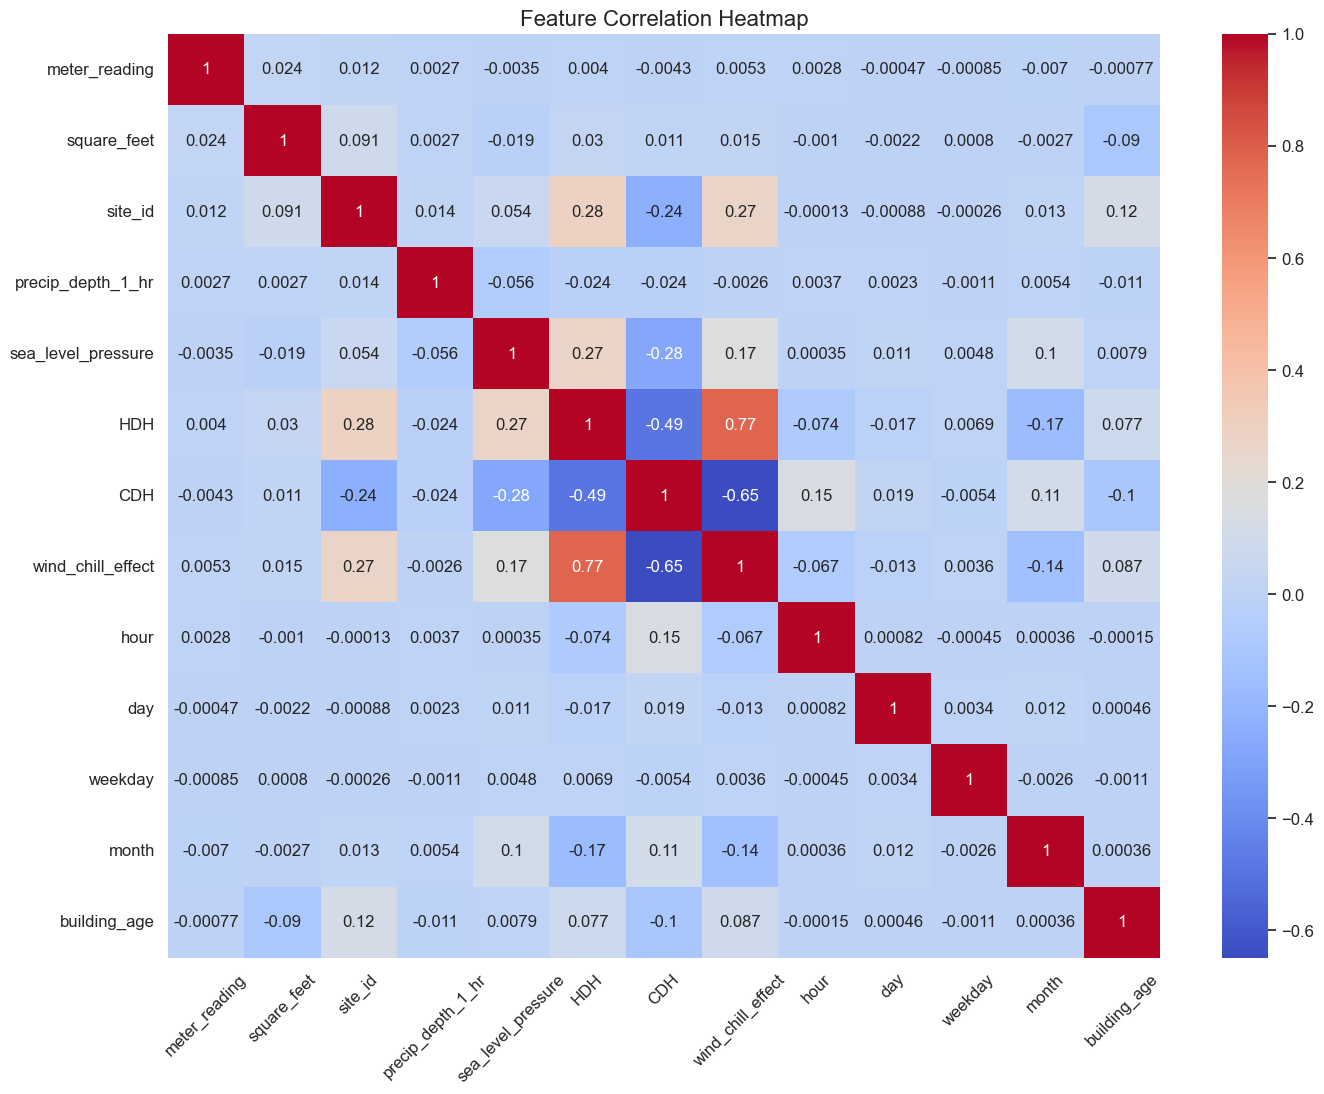

In [105]:
plt.figure(figsize=(16, 12))
columns_to_check = ['meter_reading', 'square_feet', 'site_id', 'dew_temperature', 'precip_depth_1_hr', 
                    'sea_level_pressure', 'wind_direction', 'wind_speed', 'HDH', 'CDH', 
                    'wind_chill_effect', 'hour', 'day', 'weekday', 'month', 'building_age']

existing_columns = [col for col in columns_to_check if col in train_sample.columns]
corr = train_sample[existing_columns].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

cols## Linear Regression Model

In [107]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010805 entries, 534236 to 994050
Data columns (total 22 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   building_id         1010805 non-null  int64  
 1   meter               1010805 non-null  int64  
 2   meter_reading       1010805 non-null  float64
 3   site_id             1010805 non-null  int64  
 4   primary_use         1010805 non-null  object 
 5   square_feet         1010805 non-null  int64  
 6   precip_depth_1_hr   1010805 non-null  float64
 7   sea_level_pressure  1010805 non-null  float64
 8   year                1010805 non-null  int64  
 9   HDH                 1005935 non-null  float64
 10  CDH                 1005935 non-null  float64
 11  wind_chill_effect   1003552 non-null  float64
 12  wind_sin            938282 non-null   float64
 13  wind_cos            938282 non-null   float64
 14  hour                1010805 non-null  int32  
 15  day             

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

features = ['square_feet', 'precip_depth_1_hr', 'sea_level_pressure',
            'HDH', 'CDH', 'wind_chill_effect', 'hour', 'weekday']
target = 'log_meter_reading'

X = train_sample[features]
y = train_sample[target]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Is it a right move???

In [109]:
print(X_train.isnull().sum())

X_train = X_train.dropna()
y_train = y_train[X_train.index]

X_test = X_test.dropna()
y_test = y_test[X_test.index]

print(X_train.isnull().sum())
print(X_train.info())

square_feet              0
precip_depth_1_hr        0
sea_level_pressure       0
HDH                   3911
CDH                   3911
wind_chill_effect     5853
hour                     0
weekday                  0
dtype: int64
square_feet           0
precip_depth_1_hr     0
sea_level_pressure    0
HDH                   0
CDH                   0
wind_chill_effect     0
hour                  0
weekday               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 802791 entries, 206608 to 597685
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   square_feet         802791 non-null  int64  
 1   precip_depth_1_hr   802791 non-null  float64
 2   sea_level_pressure  802791 non-null  float64
 3   HDH                 802791 non-null  float64
 4   CDH                 802791 non-null  float64
 5   wind_chill_effect   802791 non-null  float64
 6   hour                802791 non-null  int32  
 7   w

In [110]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

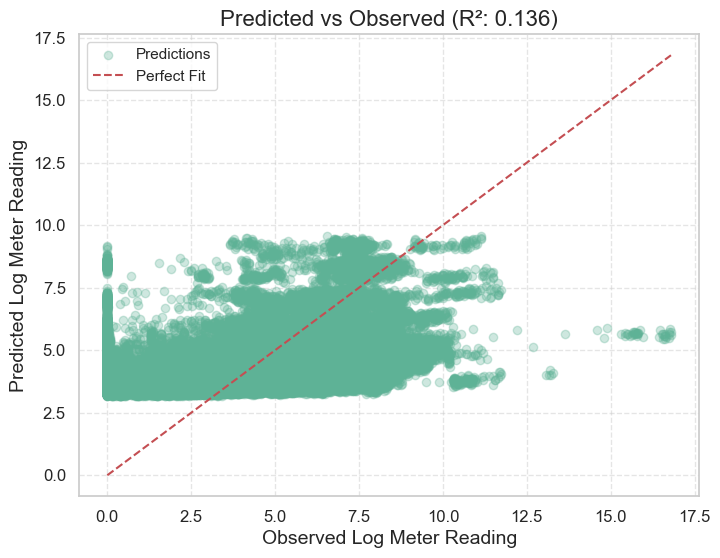

R² Score: 0.136


In [111]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.title(f'Predicted vs Observed (R²: {r2:.3f})')
plt.xlabel('Observed Log Meter Reading')
plt.ylabel('Predicted Log Meter Reading')
plt.legend()
plt.show()

print(f"R² Score: {r2:.3f}")

### Accuracy VS Complexity

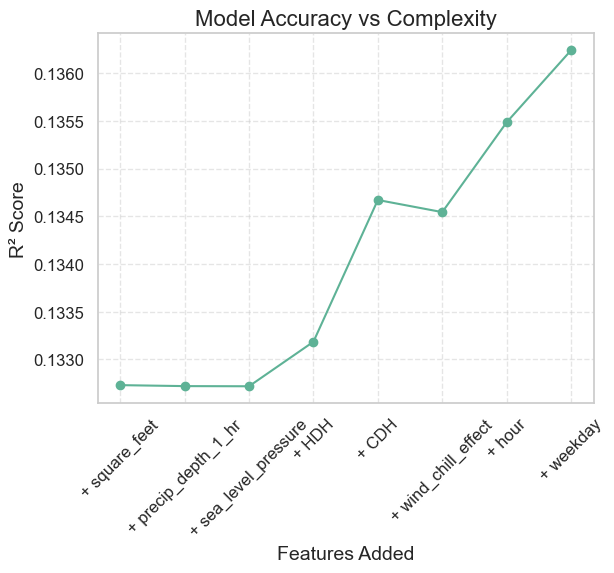

In [116]:
accuracy_scores = []

for i in range(1, len(features) + 1):
    selected_features = features[:i]
    X = train_sample[selected_features]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = X_train.dropna()
    y_train = y_train[X_train.index]

    X_test = X_test.dropna()
    y_test = y_test[X_test.index]

    model = LinearRegression()
    model.fit(X_train, y_train)

    # eval accuracy
    y_pred = model.predict(X_test)
    accuracy_scores.append(r2_score(y_test, y_pred))

plt.plot(range(1, len(features) + 1), accuracy_scores, marker='o')
plt.title('Model Accuracy vs Complexity')
plt.xlabel('Features Added')
plt.ylabel('R² Score')
plt.xticks(ticks=range(1, len(features) + 1), labels=[f'+ {feature}' for feature in features], rotation=45)
plt.show()


# Model Selection

In [117]:
val_sample = train_sample.sample(frac=0.2, random_state=random_sample_index)
train_sample = train_sample.drop(val_sample.index)
train_sample.info()
val_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 808644 entries, 38311 to 994050
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   building_id         808644 non-null  int64  
 1   meter               808644 non-null  int64  
 2   meter_reading       808644 non-null  float64
 3   site_id             808644 non-null  int64  
 4   primary_use         808644 non-null  object 
 5   square_feet         808644 non-null  int64  
 6   precip_depth_1_hr   808644 non-null  float64
 7   sea_level_pressure  808644 non-null  float64
 8   year                808644 non-null  int64  
 9   HDH                 804746 non-null  float64
 10  CDH                 804746 non-null  float64
 11  wind_chill_effect   802819 non-null  float64
 12  wind_sin            750725 non-null  float64
 13  wind_cos            750725 non-null  float64
 14  hour                808644 non-null  int32  
 15  day                 808644 non-null

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_pred, alpha=0.3, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.title(f'Random Forest: Predicted vs Observed (R²: {rf_r2:.3f})')
plt.xlabel('Observed Log Meter Reading')
plt.ylabel('Predicted Log Meter Reading')
plt.legend()
plt.show()

print(f"Random Forest R² Score: {rf_r2:.3f}")


KeyboardInterrupt: 

## K-NEAREST NEIGHBOR

In [118]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

target = 'log_meter_reading'

X_train = train_sample[features]
y_train = train_sample[target]
X_val = val_sample[features]
y_val = val_sample[target]

X_train = X_train.fillna(X_train.median())
X_val = X_val.fillna(X_val.median())

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_val)
mse_knn = mean_squared_error(y_val, y_pred_knn)
print(f'kNN Mean Squared Error: {mse_knn}')

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
mse_rf = mean_squared_error(y_val, y_pred_rf)
print(f'Random Forest Mean Squared Error: {mse_rf}')

kNN Mean Squared Error: 2.821967307073643
Random Forest Mean Squared Error: 2.6427480857812524


Installing xgboost...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.5 MB/s eta 0:00:00
xgboost installed successfully!
Gradient Boosting Mean Squared Error: 3.446181507431434
XGBoost Mean Squared Error: 3.2257582348927487
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 808644, number of used features: 8
[LightGBM] [Info] Start training from score 4.142187
LightGBM Mean Squared Error: 3.316026263664215


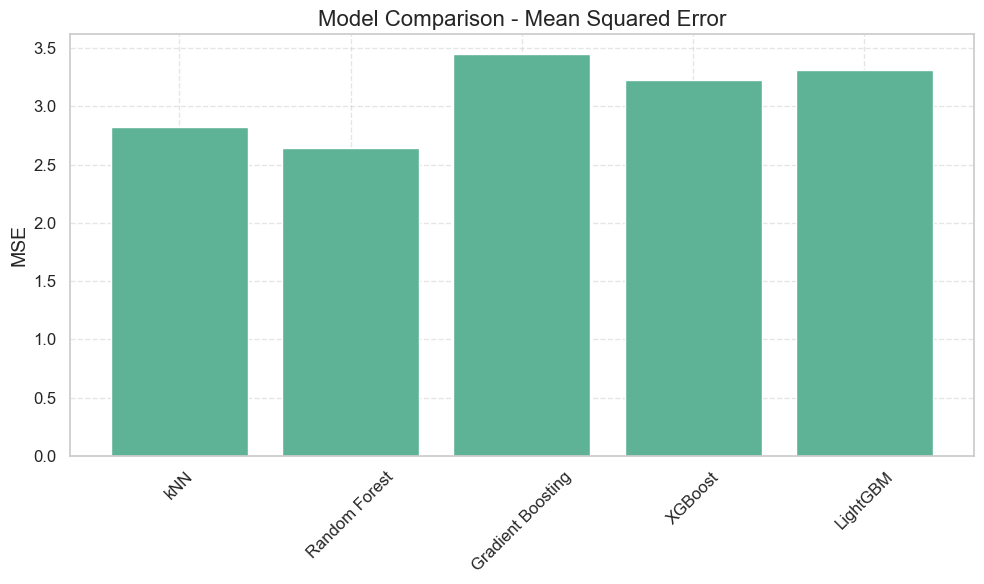

In [ ]:
# First install required packages
import sys
import subprocess

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} installed successfully!")

# Install required packages
required_packages = ['xgboost', 'lightgbm']
for package in required_packages:
    # install_package(package)

# Let's try additional ML methods that are well-suited for this regression problem

# 1. Gradient Boosting - handles non-linear relationships well and is robust to outliers
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_val)
mse_gb = mean_squared_error(y_val, y_pred_gb)
print(f'Gradient Boosting Mean Squared Error: {mse_gb}')

try:
    # 2. XGBoost - typically provides excellent performance for structured data
    import xgboost as xgb
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_val)
    mse_xgb = mean_squared_error(y_val, y_pred_xgb)
    print(f'XGBoost Mean Squared Error: {mse_xgb}')
except Exception as e:
    print(f"Error with XGBoost: {e}")
    mse_xgb = None

try:
    # 3. LightGBM - faster training and good with large datasets
    import lightgbm as lgb
    lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
    lgb_model.fit(X_train, y_train)
    y_pred_lgb = lgb_model.predict(X_val)
    mse_lgb = mean_squared_error(y_val, y_pred_lgb)
    print(f'LightGBM Mean Squared Error: {mse_lgb}')
except Exception as e:
    print(f"Error with LightGBM: {e}")
    mse_lgb = None

# Compare all models (only include successful ones)
models = {'kNN': mse_knn, 'Random Forest': mse_rf, 'Gradient Boosting': mse_gb}
if mse_xgb is not None:
    models['XGBoost'] = mse_xgb
if mse_lgb is not None:
    models['LightGBM'] = mse_lgb

plt.figure(figsize=(10, 6))
plt.bar(models.keys(), models.values())
plt.title('Model Comparison - Mean Squared Error')
plt.xticks(rotation=45)
plt.ylabel('MSE')
plt.tight_layout()
plt.show()


# Export as .html & .pdf

In [28]:
import os
NOTEBOOK_NAME = "notebook.ipynb"

# os.system(f"jupyter nbconvert --to html {NOTEBOOK_NAME}")

[NbConvertApp] Converting notebook notebook.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 23 image(s).
[NbConvertApp] Writing 3301788 bytes to notebook.html


0